In [66]:
import numpy as np

pi = np.pi

# loop through all torsions for C -- C bond
delta_ij = np.array([0, 2*pi/3, 4*pi/3, 4*pi/3, 0, 2*pi/3, 2*pi/3, 4*pi/3, 0])

#c_hidx,hidx
c_25 = 4
c_26 = 2
c_27 = 2
c_35 = 2
c_36 = 1
c_37 = 1
c_45 = 2
c_46 = 1
c_47 = 1

#c_25 = 2
#c_26 = 4
#c_27 = 2
#c_35 = 1
#c_36 = 2
#c_37 = 1
#c_45 = 1
#c_46 = 2
#c_47 = 1

c_ij = np.array([c_25, c_26, c_27, c_35, c_36, c_37, c_45, c_46, c_47])

def calc_s(delta_ij, c_ij):
    '''given ∆_(ij) returns a vector [cos(∆_(ij)), sin(∆_(ij))], s'''
    # turn into a 9X2 array
    s_ij = np.vstack((np.cos(delta_ij), np.sin(delta_ij))).T 
    
    cs_ij = c_ij[:, np.newaxis] * s_ij
    #print(f'c*s = {s_ij}')
    s = np.sum(cs_ij, axis=0)
    return s

def calc_alpha(s):
    '''given s returns a torsion angle, alpha'''
    r = np.sqrt(s[0]**2 + s[1]**2)
    #alpha = np.arctan2(r*np.cos(s[0]/r), r*np.sin(s[1]/r)) # probably wrong
    alpha = np.arctan2(s[0] / r, s[1] / r)
    
    return alpha

# rotate by some amount
gamma = 0.1

rotated_delta_ij = delta_ij + gamma
#print(f'original torsions: {delta_ij}, \nrotated torsions: {rotated_delta_ij}')

s = calc_s(delta_ij, c_ij)
#print(s)
s_rotated = calc_s(rotated_delta_ij, c_ij)
print(f'original s: {s}, \nrotated s: {s_rotated}')

a = calc_alpha(s)
a_rotated = calc_alpha(s_rotated)
#print(f'original a: {a}, \nrotated a: {a_rotated}')
#print((a_rotated - a)/pi)

print(a, a_rotated)

original s: [1.00000000e+00 1.55431223e-15], 
rotated s: [0.99500417 0.09983342]
1.570796326794895 1.4707963267948945


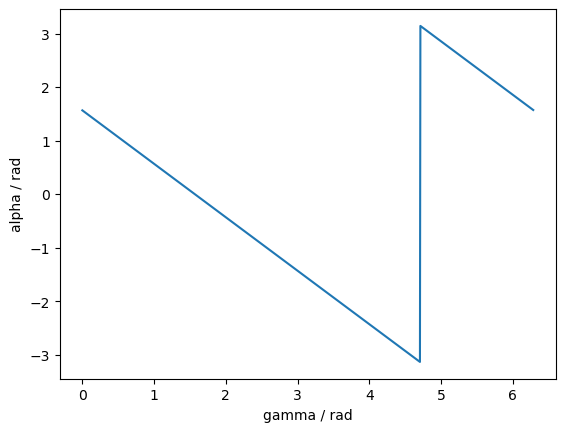

In [67]:
import pylab

rotated_delta_ij = delta_ij
a_list = []

for i in range(1000):
    gamma = 2*pi/1000

    for j in range(9):
        if rotated_delta_ij[j] + gamma < 2*pi:
            rotated_delta_ij[j] = rotated_delta_ij[j] + gamma
        else:
            rotated_delta_ij[j] = rotated_delta_ij[j] + gamma - 2*pi
        
    s_rotated = calc_s(rotated_delta_ij, c_ij)
    a_rotated = calc_alpha(s_rotated)
    a_list.append(a_rotated)

x_list = np.linspace(0, 2*pi, 1000)
pylab.plot(x_list, a_list)
pylab.ylabel("alpha / rad")
pylab.xlabel("gamma / rad")
pylab.savefig("out.png")